In [27]:
import matplotlib.pyplot as plt
import numpy as np

In [28]:
data = np.loadtxt('/Users/macbookpro/Downloads/AFM_sample1.zmat')


Constant Offset Model:
Fitted Parameters: [-1.12640957e-07]
Parameter 0: -0.0000, Std. Dev.: 0.0000, Relative Std. Dev.: -0.02%

Tilted Plane Model:
Fitted Parameters: [ 9.29005159e-08  4.19397980e-09 -8.64105688e-08]
Parameter 0: 0.0000, Std. Dev.: 0.0000, Relative Std. Dev.: 0.03%
Parameter 1: 0.0000, Std. Dev.: 0.0000, Relative Std. Dev.: 0.33%
Parameter 2: -0.0000, Std. Dev.: 0.0000, Relative Std. Dev.: -0.02%

Parabolic Surface Model:
Fitted Parameters: [ 9.82540463e-08  4.00130953e-09 -9.26571158e-08  3.90080964e-11
  1.24978343e-09 -9.48083572e-13]
Parameter 0: 0.0000, Std. Dev.: 0.0000, Relative Std. Dev.: 0.02%
Parameter 1: 0.0000, Std. Dev.: 0.0000, Relative Std. Dev.: 0.35%
Parameter 2: -0.0000, Std. Dev.: 0.0000, Relative Std. Dev.: -0.02%
Parameter 3: 0.0000, Std. Dev.: 0.0000, Relative Std. Dev.: 6.39%
Parameter 4: 0.0000, Std. Dev.: 0.0000, Relative Std. Dev.: 0.20%
Parameter 5: -0.0000, Std. Dev.: 0.0000, Relative Std. Dev.: -235.04%

Corrected Heights (Parabolic Model

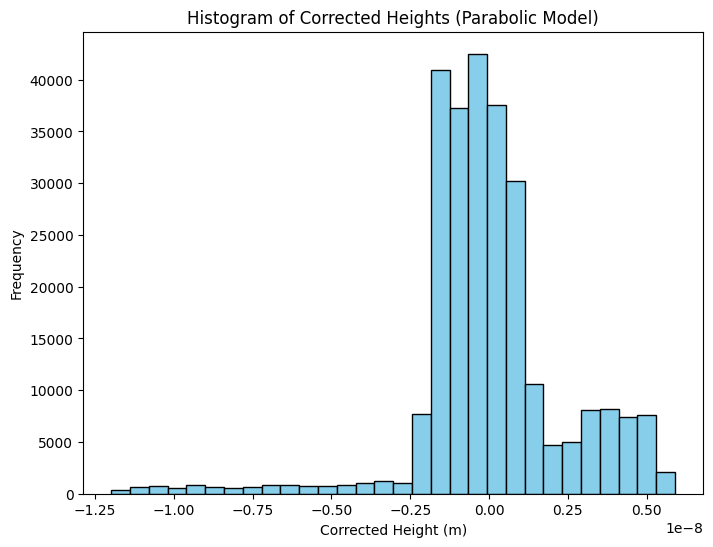

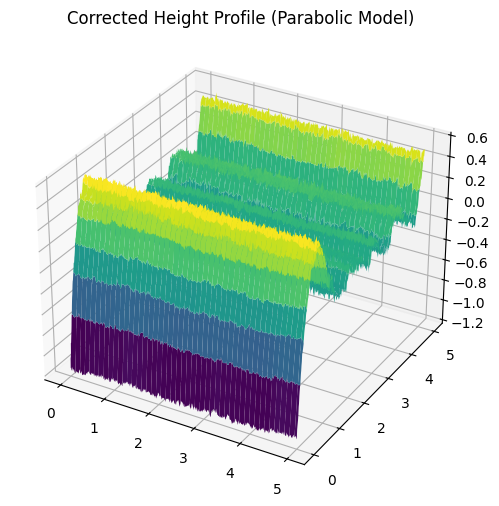

In [29]:
z = data
x = np.linspace(0, 5, data.shape[1])  # x positions in μm (assuming 512 data points)
y = np.linspace(0, 5, data.shape[0])  # y positions in μm (assuming 512 data points)
X, Y = np.meshgrid(x, y)

# Function for fitting a model using least squares
def fit_least_squares(A, z):
    return np.linalg.inv(A.T @ A) @ A.T @ z

# Models
def constant_offset(a0, x, y):
    return a0 * np.ones_like(x)

def tilted_plane(a0, a1, a2, x, y):
    return a0 + a1 * x + a2 * y

def parabolic_surface(a0, a1, a2, a3, a4, a5, x, y):
    return a0 + a1 * x + a2 * y + a3 * x**2 + a4 * y**2 + a5 * x * y

# Flatten the data for fitting
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = z.flatten()

# Fit the models
A_constant = np.ones_like(x_flat).reshape(-1, 1)
params_constant = fit_least_squares(A_constant, z_flat)

A_tilted = np.vstack([np.ones_like(x_flat), x_flat, y_flat]).T
params_tilted = fit_least_squares(A_tilted, z_flat)

A_parabolic = np.vstack([np.ones_like(x_flat), x_flat, y_flat, x_flat**2, y_flat**2, x_flat * y_flat]).T
params_parabolic = fit_least_squares(A_parabolic, z_flat)

# Residual variance
residual_variance = np.var(z_flat - parabolic_surface(*params_parabolic, x_flat, y_flat))

# Covariance matrix
C = residual_variance * np.linalg.inv(A_parabolic.T @ A_parabolic)

# Display parameters and uncertainties
def display_parameters_and_uncertainty(params, covariance_matrix):
    print("Fitted Parameters:", params)
    for i, param in enumerate(params):
        std_dev = np.sqrt(covariance_matrix[i, i])
        rel_std_dev = (std_dev / param) * 100
        print(f"Parameter {i}: {param:.4f}, Std. Dev.: {std_dev:.4f}, Relative Std. Dev.: {rel_std_dev:.2f}%")

print("\nConstant Offset Model:")
display_parameters_and_uncertainty(params_constant, C)
print("\nTilted Plane Model:")
display_parameters_and_uncertainty(params_tilted, C)
print("\nParabolic Surface Model:")
display_parameters_and_uncertainty(params_parabolic, C)

# Correct the heights
z_corrected_offset = z - constant_offset(*params_constant, X, Y)
z_corrected_tilted = z - tilted_plane(*params_tilted, X, Y)
z_corrected_parabolic = z - parabolic_surface(*params_parabolic, X, Y)

# Mean and standard deviation of corrected heights
mean_corrected = np.mean(z_corrected_parabolic)
std_corrected = np.std(z_corrected_parabolic)

print("\nCorrected Heights (Parabolic Model):")
print(f"Mean of corrected heights: {mean_corrected:.4f}")
print(f"Standard deviation of corrected heights: {std_corrected:.4f}")

# Plot a histogram of the corrected height values
plt.figure(figsize=(8, 6))
plt.hist(z_corrected_parabolic.flatten(), bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Corrected Heights (Parabolic Model)")
plt.xlabel("Corrected Height (m)")
plt.ylabel("Frequency")
plt.show()

# Visualize the corrected height profile
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, z_corrected_parabolic, cmap='viridis')
ax.set_title("Corrected Height Profile (Parabolic Model)")
plt.show()